## Compare model performance on ADS and individual tree mortality

In [1]:
import xarray as xr
import xrspatial
import rioxarray
import rioxarray.merge
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy
from matplotlib import pyplot as plt
import lightgbm as lgb
import sklearn.metrics
import json
from glob import glob
import fasttreeshap

Combine the individual tree mortality rasters into one dataset.

In [2]:
# Read everything in. Several of these files are GitHub LFS pointers. Downloading
# the original data automatically over the command line is very involved, so we keep
# copies in the data release. Also some of the files end in tiff and some are tif >:(
damage_files = glob("../data_in/nmschroeder_mortality/*_mortality*.tif*")
damage_arrs  = []

for f in damage_files:
    year = int(f.split("_")[-1][:4])
    arr = rioxarray.open_rasterio(f)
    arr = arr.squeeze(drop=True)
    arr = arr.expand_dims(time=1)
    arr = arr.assign_coords(time=[year])
    damage_arrs.append(arr)

In [3]:
# Merge datasets from the same time period in space
spatial_merge_arrs = []
unique_years = set(a.time.values[0] for a in damage_arrs)
for y in unique_years:
    arrs_to_merge = list(filter(lambda x: x.time.values[0] == y, damage_arrs))
    merged = rioxarray.merge.merge_arrays(arrs_to_merge)
    spatial_merge_arrs.append(merged)

In [4]:
# Merge datasets across years and set NAs
itm_ds = xr.combine_by_coords(spatial_merge_arrs)
itm_ds = itm_ds.where(itm_ds != itm_ds.attrs["_FillValue"])

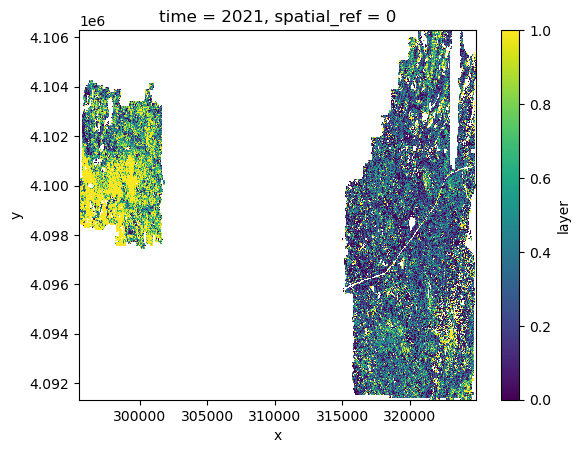

In [5]:
itm_ds.isel(time=-1).plot()

Aerial mortality and ancillary data.

In [6]:
ads_ds = xr.open_dataset("../mort_datasets/soap_teak_mort.nc").drop_vars("spatial_ref")
ads_ds

<xarray.Dataset> Size: 303MB
Dimensions:      (y: 499, x: 980, time: 24)
Coordinates:
  * x            (x) float64 8kB 2.955e+05 2.956e+05 ... 3.249e+05 3.249e+05
  * y            (y) float64 4kB 4.106e+06 4.106e+06 ... 4.091e+06 4.091e+06
  * time         (time) int64 192B 1999 2000 2001 2002 ... 2019 2020 2021 2022
Data variables: (12/16)
    elev         (y, x) float32 2MB ...
    slope        (y, x) float32 2MB ...
    northness    (y, x) float32 2MB ...
    eastness     (y, x) float32 2MB ...
    fire         (time, y, x) float32 47MB ...
    prcp         (time, y, x) float32 47MB ...
    ...           ...
    abies        (y, x) float32 2MB ...
    pinus        (y, x) float64 4MB ...
    populus      (y, x) float32 2MB ...
    pseudotsuga  (y, x) float32 2MB ...
    tsuga        (y, x) float32 2MB ...
    gfw_damage   (time, y, x) float32 47MB ...

Multiply mortality rasters by tree density. This means our target variable is number of dead trees per pixel.

In [7]:
trees_per_px = rioxarray.open_rasterio("../data_in/nmschroeder_mortality/trees_per_pixel.tiff").squeeze(drop=True)
tree_mask = trees_per_px > 0

# Mask out nonforested pixels
itm_ds = itm_ds.where(tree_mask)
ads_ds = ads_ds.where(tree_mask)

In [8]:
ads_ds["itm_mort"] = itm_ds
ads_ds["itm_norm"] = itm_ds * trees_per_px
ads_ds = ads_ds.rename(mortality="ads_mort")
ads_ds["ads_mort"] = ads_ds["ads_mort"] / 100
ads_ds["ads_norm"] = ads_ds["ads_mort"] * trees_per_px
ads_ds["trees_per_px"] = trees_per_px

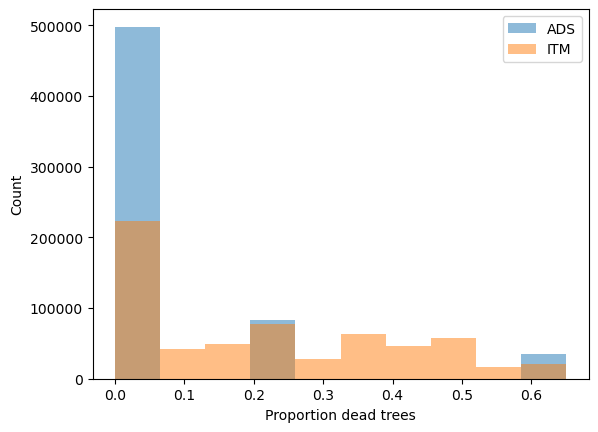

In [9]:
fig, ax = plt.subplots()
_, bins, _ = ads_ds["ads_mort"].isel(time=slice(-5, None)).plot.hist(ax=ax, label="ADS", alpha=0.5)
ads_ds["itm_mort"].plot.hist(ax=ax, label="ITM", alpha=0.5, bins=bins)
plt.legend()
plt.xlabel("Proportion dead trees")
plt.ylabel("Count")
plt.title("")
plt.show()

Prepare covariates - focal max mortality, heat load index

In [10]:
ads_ds["ads_focal_max"] = (("time", "y", "x"), scipy.ndimage.maximum_filter(ads_ds["ads_mort"].values, size=(1, 5, 5)))
ads_ds["itm_focal_max"] = (("time", "y", "x"), scipy.ndimage.maximum_filter(ads_ds["itm_mort"].values, size=(1, 5, 5)))

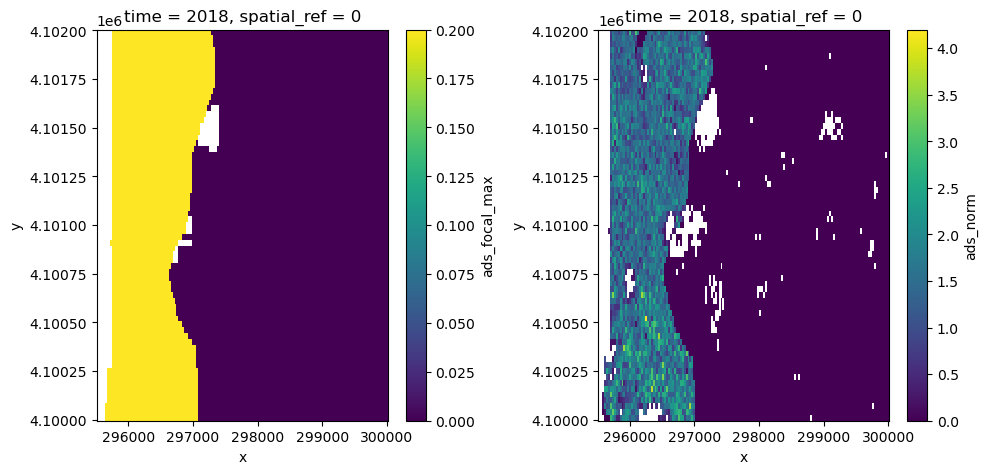

In [11]:
# Check that focal max worked as expected
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

window = dict(y=slice(4.102e6, 4.100e6), x=slice(None, 300_000), time=2018)

ads_ds.sel(**window).ads_focal_max.plot(ax=ax1)
ads_ds.sel(**window).ads_norm.plot(ax=ax2)
plt.tight_layout()
plt.show()

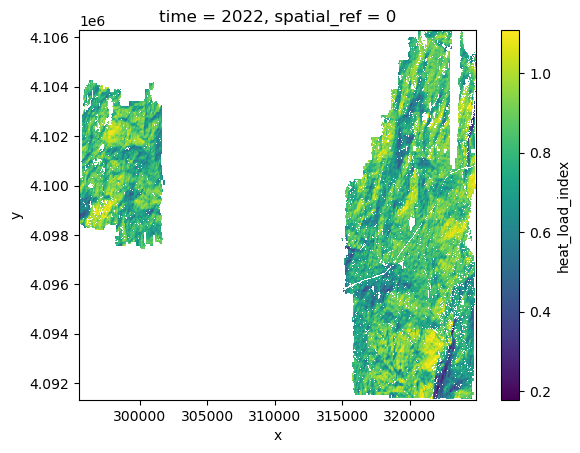

In [12]:
# Heat load index comes from 
# https://doi.org/10.1111/j.1654-1103.2002.tb02087.x
latitude = 37 * np.pi / 180 # deg north, essentially constant
ads_ds["heat_load_index"] = -1.467 +\
     1.582 * np.cos(latitude) * np.cos(ads_ds["slope"] * np.pi / 180)+\
    -1.500 * ads_ds["eastness"]/100 * np.sin(ads_ds["slope"] * np.pi / 180) * np.sin(latitude)+\
    -0.262 * np.sin(latitude) * np.sin(ads_ds["slope"] * np.pi / 180)+\
     0.607 * ads_ds["northness"]/100 * np.sin(ads_ds["slope"] * np.pi / 180)
ads_ds["heat_load_index"] = np.exp(ads_ds["heat_load_index"])
ads_ds.isel(time=-1).heat_load_index.plot()

Prepare training data. Train on 2017 using data from 2014 - 2016, then validate on 2021 using data from 2018 - 2020. No temporal dimension in the xarray objects.

In [13]:
# First collect all the time-constant variables
const_vars = ["elev", "abies", "pinus", "heat_load_index", "slope", "northness", "eastness", "trees_per_px"]
ads_const  = ads_ds[const_vars]
ads_const

<xarray.Dataset> Size: 18MB
Dimensions:          (y: 499, x: 980)
Coordinates:
  * x                (x) float64 8kB 2.955e+05 2.956e+05 ... 3.249e+05 3.249e+05
  * y                (y) float64 4kB 4.106e+06 4.106e+06 ... 4.091e+06 4.091e+06
    spatial_ref      int64 8B 0
Data variables:
    elev             (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan
    abies            (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan
    pinus            (y, x) float64 4MB nan nan nan nan nan ... nan nan nan nan
    heat_load_index  (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan
    slope            (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan
    northness        (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan
    eastness         (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan
    trees_per_px     (y, x) float32 2MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [14]:
# Collect all the climatology variables and summarize
baseline_year = 2013
train_year = 2017
valid_year = 2021

train_period = slice(baseline_year+1, train_year)
valid_period = slice(train_year, valid_year)

climate_vars = ["prcp", "vp", "tmin"]
fire_vars = ["fire"]

train_climate = ads_ds.sel(time=train_period)[climate_vars].mean(dim="time")
valid_climate = ads_ds.sel(time=valid_period)[climate_vars].mean(dim="time")

train_fire = ads_ds.sel(time=train_period)[fire_vars].mean(dim="time")
valid_fire = ads_ds.sel(time=valid_period)[fire_vars].mean(dim="time")

In [15]:
# Collect baseline mortality at the start of the period, 
# and mortality at the end of the period we are trying to predict
mort_vars = ["ads_mort", "itm_mort"]
focal_max = ["ads_focal_max", "itm_focal_max"]
train_baseline = ads_ds[mort_vars + focal_max].rename(ads_mort="ads_baseline", itm_mort="itm_baseline").sel(time=baseline_year)
valid_baseline = ads_ds[mort_vars + focal_max].rename(ads_mort="ads_baseline", itm_mort="itm_baseline").sel(time=train_year)

train_target = ads_ds[mort_vars].rename(ads_mort="ads_target", itm_mort="itm_target").sel(time=train_year)
valid_target = ads_ds[mort_vars].rename(ads_mort="ads_target", itm_mort="itm_target").sel(time=valid_year)

In [16]:
# Assemble data together
train_ds = xr.merge([ads_const, train_fire, train_baseline, train_target], compat="override")
valid_ds = xr.merge([ads_const, valid_fire, valid_baseline, valid_target], compat="override")

Define naive models. Our time step is longer here than when working with west mort so we the "baseline" vars already count as last obs. For spatial average we can take the mean over the train/validation periods.

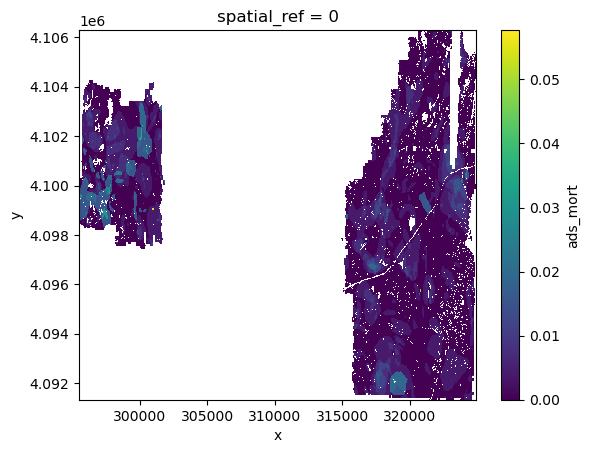

In [17]:
ads_spatial_average = ads_ds["ads_mort"].sel(time=slice(None, baseline_year)).mean(dim="time")
itm_spatial_average = ads_ds["itm_mort"].mean(dim="time")
ads_spatial_average.plot()

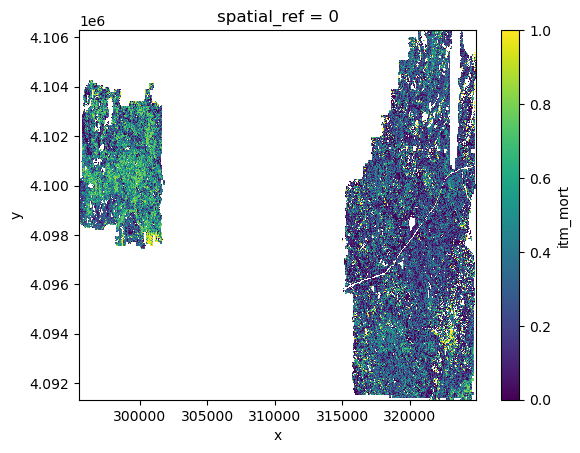

In [18]:
itm_spatial_average.plot()

Now convert all the objects to data frames. We calculate the change in canopy mortality here too in case it's interesting.

In [19]:
train_df = train_ds.to_dataframe().reset_index().dropna()
train_df["itm_delta"] = train_df["itm_target"] - train_df["itm_baseline"]
train_df["ads_delta"] = train_df["ads_target"] - train_df["ads_baseline"]
valid_df = valid_ds.to_dataframe().reset_index().dropna()
valid_df["itm_delta"] = valid_df["itm_target"] - valid_df["itm_baseline"]
valid_df["ads_delta"] = valid_df["ads_target"] - valid_df["ads_baseline"]

In [20]:
train_df.columns

Index(['y', 'x', 'elev', 'abies', 'pinus', 'heat_load_index', 'slope',
       'northness', 'eastness', 'trees_per_px', 'spatial_ref', 'fire',
       'ads_baseline', 'itm_baseline', 'ads_focal_max', 'itm_focal_max',
       'time', 'ads_target', 'itm_target', 'itm_delta', 'ads_delta'],
      dtype='object')

In [21]:
df_merge = pd.concat((train_df, valid_df)).sample(frac=1)

train_df = df_merge.iloc[1:int(np.floor(df_merge.shape[0]*0.8)), :]
valid_df = df_merge.iloc[int(np.floor(df_merge.shape[0]*0.8)):,  :]

In [22]:
itm_vars = ["itm_baseline", "itm_focal_max"]
ads_vars = ["ads_baseline", "ads_focal_max"]

itm_target = ["itm_target"]
ads_target = ["ads_target"]

def split_xy(df, target):
    return (
        df.reset_index(drop=True).drop(columns=target).to_numpy(),
        df.reset_index(drop=True)[target].to_numpy().flatten()
    )

X_ads_train, y_ads_train = split_xy(train_df[const_vars+fire_vars+ads_vars+ads_target], ads_target)
X_itm_train, y_itm_train = split_xy(train_df[const_vars+fire_vars+itm_vars+itm_target], itm_target)
print("ADS size:", X_ads_train.shape)
print("ITM size:", X_itm_train.shape)

ADS size: (5084, 11)
ITM size: (5084, 11)


In [23]:
def make_estimator():
    return lgb.LGBMRegressor(min_data_in_leaf=100, verbosity=-1)

rf_ads = make_estimator()
rf_itm = make_estimator()

rf_ads.fit(X_ads_train, y_ads_train)
rf_itm.fit(X_itm_train, y_itm_train)

LGBMRegressor(min_data_in_leaf=100, verbosity=-1)

In [24]:
# Second run without autocorrelation features
X_ads_noac_train, _ = split_xy(train_df[const_vars+fire_vars+ads_target], ads_target)
X_itm_noac_train, _ = split_xy(train_df[const_vars+fire_vars+itm_target], itm_target)

rf_ads_noac = make_estimator()
rf_itm_noac = make_estimator()

rf_ads_noac.fit(X_ads_noac_train, y_ads_train)
rf_itm_noac.fit(X_itm_noac_train, y_itm_train)

LGBMRegressor(min_data_in_leaf=100, verbosity=-1)

In [25]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

def get_results(y, y_hat):
    mse = mean_squared_error(y, y_hat)
    nrmse = np.sqrt(mse) / np.std(y)
    r2 = r2_score(y, y_hat)
    ev = explained_variance_score(y, y_hat)
    return {
        "mse": mse,
        "nrmse": nrmse,
        "r2": r2,
        "exp_var": ev
    }

print("ADS model training")
print(get_results(y_ads_train, rf_ads.predict(X_ads_train)))

print("ITM model training")
print(get_results(y_itm_train, rf_itm.predict(X_itm_train)))

print("ADS model noac training")
print(get_results(y_ads_train, rf_ads_noac.predict(X_ads_noac_train)))

print("ITM model noac training")
print(get_results(y_itm_train, rf_itm_noac.predict(X_itm_noac_train)))

ADS model training
{'mse': 9.254863279215359e-05, 'nrmse': 0.6280327410003211, 'r2': 0.6055748543708271, 'exp_var': 0.6055748574008942}
ITM model training
{'mse': 0.03068968645667802, 'nrmse': 0.5482075337690796, 'r2': 0.6994685136453871, 'exp_var': 0.699468505607655}
ADS model noac training
{'mse': 9.155287700766212e-05, 'nrmse': 0.6246450168917295, 'r2': 0.6098185812467409, 'exp_var': 0.6098185842442067}
ITM model noac training
{'mse': 0.03849311808444723, 'nrmse': 0.6139603426766331, 'r2': 0.6230527148371927, 'exp_var': 0.6230527047557155}


X does not have valid feature names, but LGBMRegressor was fitted with feature names
X does not have valid feature names, but LGBMRegressor was fitted with feature names
X does not have valid feature names, but LGBMRegressor was fitted with feature names
X does not have valid feature names, but LGBMRegressor was fitted with feature names


In [26]:
X_ads_valid, y_ads_valid = split_xy(valid_df[const_vars+fire_vars+ads_vars+ads_target], ads_target)
X_itm_valid, y_itm_valid = split_xy(valid_df[const_vars+fire_vars+itm_vars+itm_target], itm_target)

y_hat_itm = rf_itm.predict(X_itm_valid)
y_hat_ads = rf_ads.predict(X_ads_valid)

print("ADS model validation")
ads_rf_result = get_results(y_ads_valid, y_hat_ads)
print(ads_rf_result)

print("ITM model validation")
itm_rf_result = get_results(y_itm_valid, y_hat_itm)
print(itm_rf_result)

ADS model validation
{'mse': 6.221209791579477e-05, 'nrmse': 0.7043766339293474, 'r2': 0.5038536275909807, 'exp_var': 0.5039334113789044}
ITM model validation
{'mse': 0.04378001298225768, 'nrmse': 0.6521065675415656, 'r2': 0.5747570741742147, 'exp_var': 0.5749093147397462}


X does not have valid feature names, but LGBMRegressor was fitted with feature names
X does not have valid feature names, but LGBMRegressor was fitted with feature names


In [27]:
X_ads_noac_valid, _ = split_xy(valid_df[const_vars+fire_vars+ads_target], ads_target)
X_itm_noac_valid, _ = split_xy(valid_df[const_vars+fire_vars+itm_target], itm_target)

y_hat_itm_noac = rf_itm_noac.predict(X_itm_noac_valid)
y_hat_ads_noac = rf_ads_noac.predict(X_ads_noac_valid)

print("ADS noac model validation")
ads_noac_rf_result = get_results(y_ads_valid, y_hat_ads_noac)
print(ads_rf_result)

print("ITM noac model validation")
itm_noac_rf_result = get_results(y_itm_valid, y_hat_itm_noac)
print(itm_noac_rf_result)

ADS noac model validation
{'mse': 6.221209791579477e-05, 'nrmse': 0.7043766339293474, 'r2': 0.5038536275909807, 'exp_var': 0.5039334113789044}
ITM noac model validation
{'mse': 0.05460414088706052, 'nrmse': 0.7282716772046601, 'r2': 0.4696204260508746, 'exp_var': 0.4696701517228138}


X does not have valid feature names, but LGBMRegressor was fitted with feature names
X does not have valid feature names, but LGBMRegressor was fitted with feature names


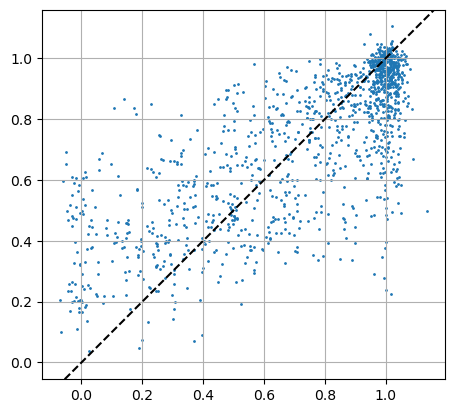

In [28]:
def with_jitter(arr):
    stdev = np.std(arr) * 0.1
    return arr + np.random.randn(*arr.shape)*stdev

fig, ax = plt.subplots()
ax.grid()
ax.scatter(with_jitter(y_itm_valid), y_hat_itm, s=1)
ax.set_aspect("equal")
ax.axline((0, 0), slope=1, color="black", linestyle="--")

Calculate naive model performance. We don't do spatial average for the ITM dataset because there are only three time points, so a mean across the three would be very similar to the baseline models.

In [29]:
'''
itm_delta_2017 = ads_ds["itm_mort"].sel(time=2017) 
itm_delta_2021 = ads_ds["itm_mort"].sel(time=2021)

# is the observed delta in 2017 predictive of future change in 2021?
itm_delta_2017 = itm_delta_2017.data.flatten()
itm_delta_2021 = itm_delta_2021.data.flatten()

mask = ~(np.isnan(itm_delta_2017) | np.isnan(itm_delta_2021))

itm_delta_2017 = itm_delta_2017[mask]
itm_delta_2021 = itm_delta_2021[mask]
'''

itm_lastobs = get_results(valid_df["itm_target"], valid_df["itm_baseline"])
print("ITM previous observation")
print(itm_lastobs)

ITM previous observation
{'mse': 0.21603873372077942, 'nrmse': 1.4485930669553702, 'r2': -1.0984220504760742, 'exp_var': 0.10145634412765503}


In [30]:
print("ADS previous observation")
ads_lastobs = get_results(y_ads_valid, valid_df["ads_baseline"])
print(ads_lastobs)

ADS previous observation
{'mse': 0.04928458482027054, 'nrmse': 19.825450675638056, 'r2': -392.0484619140625, 'exp_var': -347.1887512207031}


In [31]:
# These arrays have the same shape so we can happily flatten them and mask
ads_avg_df = ads_spatial_average.rename("ads_spatavg").to_dataframe().drop(columns=["spatial_ref"]).dropna()

ads_valid_join = valid_df[["y", "x", "ads_target"]].set_index(["y", "x"]).join(ads_avg_df).dropna()

print("ADS long-term spatial average")
ads_timeavg = get_results(ads_valid_join["ads_target"], ads_valid_join["ads_spatavg"])
print(ads_timeavg)

ADS long-term spatial average
{'mse': 0.00017784042574930936, 'nrmse': 1.1909203762569405, 'r2': -0.4182915687561035, 'exp_var': -0.3391237258911133}


Collect all the results together in a dataframe.

In [32]:
ads_timeavg["model"] = "spatial average"
ads_timeavg["data"] = "ADS"
ads_lastobs["model"] = "last observation"
ads_lastobs["data"] = "ADS"
itm_lastobs["model"] = "last observation"
itm_lastobs["data"] = "ITM"
ads_noac_rf_result["model"] = "RF noac"
ads_noac_rf_result["data"] = "ADS"
itm_noac_rf_result["model"] = "RF noac"
itm_noac_rf_result["data"] = "ITM"
ads_rf_result["model"] = "RF full"
ads_rf_result["data"] = "ADS"
itm_rf_result["model"] = "RF full"
itm_rf_result["data"] = "ITM"

In [33]:
all_results = pd.DataFrame([
    ads_timeavg,
    ads_lastobs,
    itm_lastobs,
    ads_noac_rf_result,
    itm_noac_rf_result,
    ads_rf_result,
    itm_rf_result
])

#all_results.to_csv("../data_out/soap_teak_rf_result.csv")

In [34]:
all_results.sort_values(["data", "model"])

,mse,nrmse,r2,exp_var,model,data
5,0.000062,0.704377,0.503854,0.503933,RF full,ADS
3,0.000062,0.705633,0.502082,0.502184,RF noac,ADS
1,0.049285,19.825451,-392.048462,-347.188751,last observation,ADS
0,0.000178,1.190920,-0.418292,-0.339124,spatial average,ADS
6,0.043780,0.652107,0.574757,0.574909,RF full,ITM
4,0.054604,0.728272,0.469620,0.469670,RF noac,ITM
2,0.216039,1.448593,-1.098422,0.101456,last observation,ITM


### SHAP Analysis

Now we want to see what is driving predictions in the full ITM RF. To do so we use FastTreeSHAP.

In [35]:
%%time
explainer = fasttreeshap.TreeExplainer(rf_itm, algorithm="auto")
values = explainer(X_itm_valid).values
print(values.shape)

(1272, 11)
CPU times: user 1.12 s, sys: 9.85 ms, total: 1.13 s
Wall time: 362 ms


*nyooooooooooooooom*

In [36]:
feature_names = const_vars+fire_vars+itm_vars
#pd.DataFrame(values, columns=feature_names).to_csv("../data_out/soap_itm_shap_values.csv")

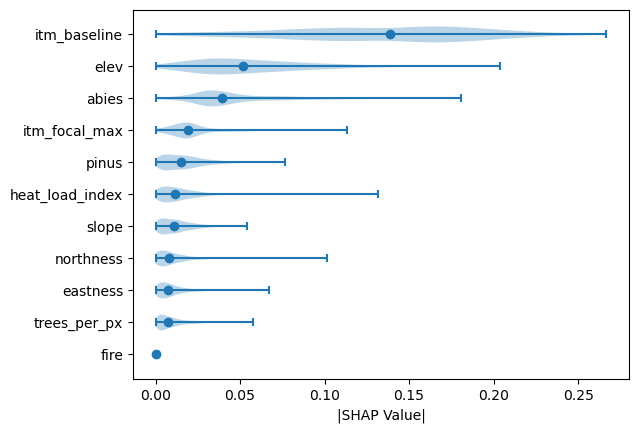

In [37]:
abs_shap = np.abs(values)
median_abs = np.median(abs_shap, axis=0)

# Sort by descending median
sort_arg = np.argsort(median_abs)

abs_shap_sort = abs_shap[:, sort_arg]
feature_names_sort = [feature_names[i] for i in sort_arg]

plt.violinplot(abs_shap_sort, vert=False)
plt.scatter(median_abs[sort_arg], range(1, len(feature_names)+1))
plt.yticks(ticks=range(1, len(feature_names)+1), labels=feature_names_sort)
plt.xlabel("|SHAP Value|")
plt.show()

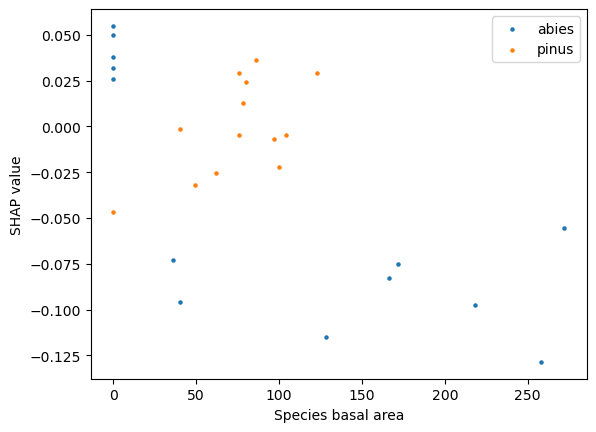

In [38]:
feat1 = "abies"
feat2 = "pinus"
ind1 = feature_names.index(feat1)
ind2 = feature_names.index(feat2)

downsample_factor = 100

plt.scatter(X_itm_valid[::downsample_factor, ind1], values[::downsample_factor, ind1], s=5, label=feat1)
plt.scatter(X_itm_valid[::downsample_factor, ind2], values[::downsample_factor, ind2], s=5, label=feat2)
plt.xlabel("Species basal area")
plt.ylabel("SHAP value")
plt.legend()
plt.show()

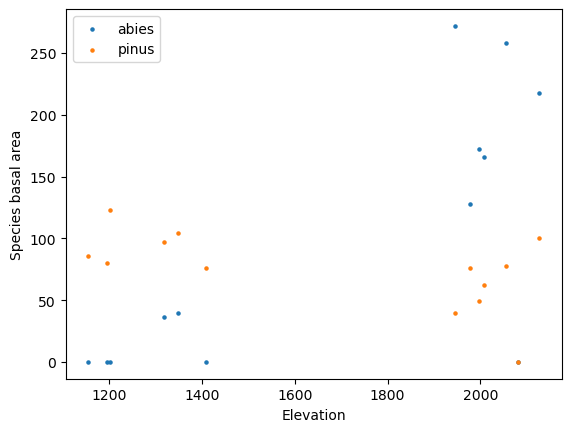

In [39]:
feat3 = "elev"
ind3 = feature_names.index(feat3)

plt.scatter(X_itm_valid[::downsample_factor, ind3], X_itm_valid[::downsample_factor, ind1], s=5, label=feat1)
plt.scatter(X_itm_valid[::downsample_factor, ind3], X_itm_valid[::downsample_factor, ind2], s=5, label=feat2)

plt.xlabel("Elevation")
plt.ylabel("Species basal area")
plt.legend()
plt.show()

Text(0, 0.5, 'SHAP Value')

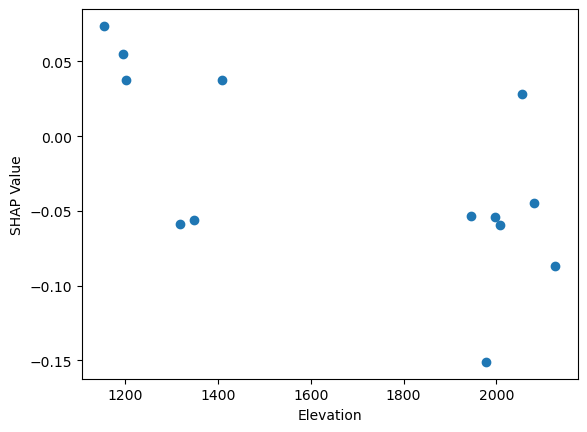

In [40]:
plt.scatter(X_itm_valid[::downsample_factor, ind3], values[::downsample_factor, ind3])
plt.xlabel("Elevation")
plt.ylabel("SHAP Value")